# Cuadratura Gaussiana

In [1]:
import numpy as np
import sympy as sym

In [2]:
x = sym.Symbol('x',real=True)
y = sym.Symbol('y',real=True)

Seguimos con el problema de integrar una función $f(x)$ en cierto intervalo \[a,b\] mediante su cuadratura. Es decir, realizando una suma con pesos de la función en ciertos nodos

$$\begin{align*}
\int_a^b f(x) dx = \sum_{k=0}^{n-1} c_k f(x_k)
\end{align*}
$$

## Gauss-Legendre

La aproximación de Gauss-Legendre consiste en encontrar los $k$ nodos y pesos tal que 
    $$ \begin{align*}
        \int_{-1}^1 f(x) dx &= \sum_{k=0}^{n-1} c_k f(x_k) 
    \end{align*}$$
    Se puede demostrar que para $n$ nodos, estos están dados por los ceros de los *Polinomios de Legendre*, definidos mediante la fórmula de Rodrigues como

$$ \begin{align*}
P_n(x) &= \frac{1}{2^n n!} \frac{d^n}{dx^n}(x^2-1)^n
\end{align*} $$

A partir de esto, se puede crear una función en Python que retorne el $n$-ésimo polinomio de Legendre.

In [3]:
def GetLegendre(n,x,y):
    
    y = (x**2 - 1)**n
    
    poly = sym.diff( y,x,n )/(2**n*np.math.factorial(n))
    
    return poly

Los polinomios de Legendre también satisfacen la ecuación de recursión

$$
\begin{align*}
(n+1)P_{n+1}(x) &= (2n+1)xP_n(x)-nP_{n-1}(x),
\end{align*}
$$

por lo que se puede escribir la función anterior de forma recursiva.

In [4]:
def GetLegendreRecursive(n,x):

    if n==0:
        poly = sym.Number(1)
    elif n==1:
        poly = x
    else:
        poly = ((2*n-1)*x*GetLegendreRecursive(n-1,x)-(n-1)*GetLegendreRecursive(n-2,x))/n
   
    return sym.expand(poly,x)

Veamos un ejemplo de estos polinomios para distintos $n$,

In [5]:
GetLegendreRecursive(0,x)

1

In [6]:
GetLegendreRecursive(1,x)

x

In [7]:
GetLegendreRecursive(3,x)

5*x**3/2 - 3*x/2

Para encontrar sus ceros, utilizamos el método de Newton-Rhapson teniendo en cuenta que el $n$-ésimo polinomio tendrá $n$ raíces. Antes de eso, encontremos la derivada de Legendre,

In [8]:
def GetDLegendre(n,x):
    Pn = GetLegendreRecursive(n,x)
    return sym.diff(Pn,x,1)

In [9]:
def GetNewton(f,df,xn,itmax=10000,precision=1e-14):
    
    error = 1.
    it = 0
    
    while error >= precision and it < itmax:
        
        try:
            
            xn1 = xn - f(xn)/df(xn)
            
            error = np.abs(f(xn)/df(xn))
            
        except ZeroDivisionError:
            print('Zero Division')
            
        xn = xn1
        it += 1
        
    if it == itmax:
        return False
    else:
        return xn

In [10]:
def GetRoots(f,df,x,tolerancia = 10):
    
    Roots = np.array([])
    
    for i in x:
        
        root = GetNewton(f,df,i)

        if  type(root)!=bool:
            croot = np.round( root, tolerancia )
            
            if croot not in Roots:
                Roots = np.append(Roots, croot)
                
    Roots.sort()
    
    return Roots

In [11]:
def GetAllRootsGLeg(n):

    xn = np.linspace(-1,1,100)
    
    Legendre = []
    DLegendre = []
    
    for i in range(n+1):
        Legendre.append(GetLegendreRecursive(i,x))
        DLegendre.append(GetDLegendre(i,x))
    
    poly = sym.lambdify([x],Legendre[n],'numpy')
    Dpoly = sym.lambdify([x],DLegendre[n],'numpy')
    Roots = GetRoots(poly,Dpoly,xn)

    if len(Roots) != n:
        ValueError('El número de raíces debe ser igual al n del polinomio.')
    
    return Roots

In [12]:
GetAllRootsGLeg(3)

array([-0.77459667,  0.        ,  0.77459667])

Los pesos de Gauss-Legendre están dados a su vez por 
    $$ \begin{align*}
        c_k &= \frac{2}{(1-x_k^2)[P_n'(x_k)]^2}
    \end{align*}$$
    donde $x_k$ es el $k$-ésimo cero del polinomio $n$-ésimo de Legendre, por lo que se puede escribir una función en python que dado un $n$, retorne el arreglo de pesos de Gauss-Legendre. 

In [13]:
def GetWeightsGLeg(n):

    Roots = GetAllRootsGLeg(n)

    

    DLegendre = []
    
    for i in range(n+1):
        DLegendre.append(GetDLegendre(i,x))
    
    Dpoly = sym.lambdify([x],DLegendre[n],'numpy')
    Weights = 2/((1-Roots**2)*Dpoly(Roots)**2)
    
    return Weights

In [14]:
raices = GetAllRootsGLeg(5)

In [15]:
pesos = GetWeightsGLeg(5)

In [16]:
funcion = lambda x: x**4

In [17]:
I = 0
for i in range(5):
    I += pesos[i]*funcion(raices[i])

In [18]:
I

0.40000000006796044

---

## Gauss-Laguerrre

La aproximación de Gauss-Laguerre consiste en encontrar los $k$ nodos y pesos tal que 
    $$ \begin{align*}
        \int_{0}^\infty e^{-x} f(x) dx &= \sum_{k=0}^{n-1} c_k f(x_k) 
    \end{align*}$$
    Se puede demostrar que para $n$ nodos, estos están dados por los ceros de los *Polinomios de Laguerre*, definidos mediante la fórmula de Rodrigues como

$$ \begin{align*}
L_n(x) &= \frac{e^x}{n!} \frac{d^n}{dx^n}(e^{-x}x^n)
\end{align*} $$

A partir de esto, se puede crear una función en Python que retorne el $n$-ésimo polinomio de Laguerre. Los polinomios de Laguerre también satisfacen la ecuación de recursión

$$
\begin{align*}
L_{k+1} &= \frac{(2k+1-x)L_k(x)-kL_{k-1}(x)}{k+1}
\end{align*}
$$

por lo que se puede escribir la función anterior de forma recursiva teniendo en cuenta que $L_0(x)=1, L_1(x)=1-x$.

**Ejercicio 3.1**
1. Escriba una función `GetLaguerre(n,x)` que retorne el $n$-ésimo polinomio de Laguerre de forma recursiva.
2. Escriba una función `GetAllRootsGLag(n)` que encuentre todas las raíces del $n$-ésimo polinomio de Laguerre. Para esto, utilize el hecho de que las raíces están acotadas en el intervalo $(0,n+(n-1)\sqrt{n})$
3. Escriba una función `GetWeightsGLag(n)` que encuentre los $n$-pesos del $n$-ésimo polinomio de Laguerre. Tenga en cuenta que estos pesos están dados por 
$$
\begin{align*}
c_k &= \frac{x_k}{(n+1)^2 [L_{n+1}(x_k)]^2}
\end{align*}
$$


### **1**

In [19]:
def GetLaguerre(n,x):
    
    if n==0:
        return 1
    
    elif n==1:
        return 1-x
    
    else:
        poly = ((2*(n-1)+1-x)*GetLaguerre(n-1,x)-(n-1)*GetLaguerre(n-2,x))/n
        return poly
    
        
    print("error")
    

### **Ejemplo:** Polinomio Laguerre de grado 2

In [20]:
GetLaguerre(2,x)

(1 - x)*(3 - x)/2 - 1/2

### **2**

In [21]:
def GetAllRootsGlag(n):
    
    tolerancia = 14
    xn = np.linspace(0,n+(n-1)*np.sqrt(n),50)
    
    poly = GetLaguerre(n,x)
    df_poly = sym.diff(poly,x,1)
    
    poly = sym.lambdify(x,poly,'numpy')
    df_poly = sym.lambdify(x,df_poly,'numpy')
    
    Roots = np.array([])
    
    for i in xn:
        
        root = GetNewton(poly,df_poly,i)
        #print(type(root))
        if  type(root)!=bool:
            croot = np.round(root, tolerancia)
            if croot not in Roots:
                Roots = np.append(Roots, croot)
                
    Roots.sort()
    
    return Roots

### **Ejemplo:** Raices del polinomio de Laguerre de grado 2

In [22]:
GetAllRootsGlag(2)

array([0.58578644, 3.41421356])

### **3**

$$
\begin{align*}
c_k &= \frac{x_k}{(n+1)^2 [L_{n+1}(x_k)]^2}
\end{align*}
$$


In [23]:
def GetWeightsGLag(n):
    Roots = GetAllRootsGlag(n)
    #n+1-esimo polinomio de laguerre
    poly = GetLaguerre(n+1,x)
    poly = sym.lambdify(x,poly,'numpy')
    return Roots/(((n+1)**2)*(poly(Roots))**2)

### **Ejemplo:** Pesos del polinomio de Laguerre de grado 2

In [24]:
GetWeightsGLag(2)

array([0.85355339, 0.14644661])

---

## Gauss-Hermite

La aproximación de Gauss-Hermite consiste en encontrar los $k$ nodos y pesos tal que 
    $$ \begin{align*}
        \int_{-\infty}^\infty e^{-x^2} f(x) dx &= \sum_{k=0}^{n-1} c_k f(x_k) 
    \end{align*}$$
    Se puede demostrar que para $n$ nodos, estos están dados por los ceros de los *Polinomios de Hermite*, definidos mediante la fórmula de Rodrigues como

$$ \begin{align*}
H_n(x) &= (-1)^n e^{x^2} \frac{d^n}{dx^n}e^{-x^2}
\end{align*} $$

A partir de esto, se puede crear una función en Python que retorne el $n$-ésimo polinomio de Hermite. Los polinomios de Hermite también satisfacen la ecuación de recursión

$$
\begin{align*}
H_{n+1}(x) = 2xH_n(x)-2nH_{n-1}(x)
\end{align*}
$$

por lo que se puede escribir la función anterior de forma recursiva teniendo en cuenta que $H_0(x)=1, H_1(x)=2x$.

**Ejercicio 3.2**
1. Escriba una función `GetHermite(n,x)` que retorne el $n$-ésimo polinomio de Hermite de forma recursiva.
2. Escriba una función `GetAllRootsGHer(n)` que encuentre todas las raíces del $n$-ésimo polinomio de Hermite. Para esto, utilize el hecho de que las raíces están acotadas en el intervalo $(-\sqrt{4n+1},\sqrt{4n+1})$
3. Escriba una función `GetWeightsGHer(n)` que encuentre los $n$-pesos del $n$-ésimo polinomio de Hermite. Tenga en cuenta que estos pesos están dados por 
$$
\begin{align*}
c_k &= \frac{2^{n-1}n! \sqrt{\pi}}{n^2[H_{n-1}(x_k)]^2}
\end{align*}
$$


### **1**

In [25]:
def GetHermite(n,x):
    if n==0:
        return 1
    elif n==1:
        return 2*x
    else:
        return 2*x*GetHermite(n-1,x)-2*(n-1)*GetHermite(n-2,x)

### **Ejemplo:** Polinomio Hermite de grado 2

In [26]:
GetHermite(3,x)

2*x*(4*x**2 - 2) - 8*x

### **2**

In [27]:
def GetAllRootsGHer(n):
    tolerancia = 14
    xn = np.linspace(-np.sqrt(4*n+1),np.sqrt(4*n+1),50)
    
    poly = GetHermite(n,x)
    df_poly = sym.diff(poly,x,1)
    
    poly = sym.lambdify(x,poly,'numpy')
    df_poly = sym.lambdify(x,df_poly,'numpy')
    
    Roots = np.array([])
    
    for i in xn:
        
        root = GetNewton(poly,df_poly,i)
        #print(type(root))
        if  type(root)!=bool:
            croot = np.round(root, tolerancia)
            if croot not in Roots:
                Roots = np.append(Roots, croot)
                
    Roots.sort()
    
    return Roots
    

### **Ejemplo:** Raices del polinomio de Hermite de grado 4

In [28]:
GetAllRootsGHer(4)

array([-1.65068012, -0.52464762,  0.52464762,  1.65068012])

### **3**

$$
\begin{align*}
c_k &= \frac{2^{n-1}n! \sqrt{\pi}}{n^2[H_{n-1}(x_k)]^2}
\end{align*}
$$

In [29]:
def GetWeightsGHer(n):
    Roots = GetAllRootsGHer(n)
    #n-1 -esimo polinomio de hermite
    poly = GetHermite(n-1,x)
    poly = sym.lambdify(x,poly,'numpy')
    numerador = 2**(n-1)*np.math.factorial(n)*np.sqrt(np.pi)
    denominador = n**2*(poly(Roots))**2
    return numerador/denominador
    

### **Ejemplo:** Pesos del polinomio de Hermite de grado 4

In [30]:
GetWeightsGHer(4)

array([0.08131284, 0.80491409, 0.80491409, 0.08131284])

## Aplicaciones

### Utilizando la cuadratura **Gauss-Laguerre**, resuelva:

En 1852, el físico escocés James Clerk Maxwell describió la distribución de velocidades de moléculas de un gas como 

$$
\begin{align*}
    P(v) &= 4\pi \left( \frac{M}{2\pi R T} \right)^{3/2} v^2 \exp \left( - \frac{Mv^2}{2RT} \right)
\end{align*}
$$


1. Demuestre que $\int_0^\infty P(v) dv =1$, es decir, que es una distribución de probabilidad.
2. Grafique $P(v)$ para distintas temperaturas. ¿Qué puede decir de la velocidad más probable (con mayor $P(v)$) a medida que aumenta la temperatura?
3. Para 10 distintas temperaturas, encuentre la *velocidad promedio*
    
$$
\begin{align*}
v_{avg} &= \int_0^\infty vP(v) dv
    \end{align*}
$$

Grafique (en escala logarítmica) $v_{avg}$ y $T$ y verifique que se cumple

$$
\begin{align*}
    v_{avg} &= \sqrt{\frac{8RT}{\pi M}}
\end{align*}
$$
4. Para 10 distintas temperaturas, encuentre la velocidad media cuadrática
$$
\begin{align*}
        v_{rms} &= \sqrt{\int_{0}^\infty v^2 P(v) dv} 
    \end{align*}
$$

Grafique (en escala logarítmica) $v_{rms}$ y $T$ y verifique que se cumple

$$
\begin{align*}
        v_{rms} &= \sqrt{\frac{3RT}{M}}
    \end{align*}
$$
5. Usando lo anterior, demuestre que la energía interna de un gas está dada por $E_{int}=\frac{3}{2}nRT$

In [31]:
from matplotlib import pyplot as plt
import numpy as np
import sympy as sym

### Distribucion Maxwell-Boltzmann:

In [32]:
helium_m = 4.002602*1e-26
boltzmann_k = 1.3806491e-23
#xenon_m =2.1848297*1e-25
def MaxwBltz(v,M=helium_m,R=boltzmann_k,T=298.15):
    return 4*np.pi*(M/(2*np.pi*R*T))**(3/2)*(v**2)*np.exp(-(M*(v**2))/(2*R*T))

### 3.3.1

$$ \begin{align*}
    \int_{0}^\infty e^{-x} f(x) dx &= \sum_{k=0}^{n-1} c_k f(x_k) 
\end{align*}$$

In [33]:
n = 7
x = sym.Symbol('x',real=True)
xk = GetAllRootsGlag(n)
ck = GetWeightsGLag(n)

Sea $u=\frac{Mv^2}{2RT}$. Entonces la función de densidad pasa a ser:

$P(u) = 4\pi(\frac{M}{2\pi RT})^\frac{3}{2}\cdot \frac{2RT\cdot u}{M}\cdot e^{-u}$

Y entonces 

$\int_{0}^{\infty}P(v)dv = \int_{0}^{\infty}P(u)\cdot\frac{2RT}{2M\sqrt(\frac{2RTu}{M})} du  $

Sea

$f(u) =\frac{2RT\cdot u}{M}\cdot 4\pi(\frac{M}{2\pi RT})^\frac{3}{2}\cdot\frac{2RT}{2M\sqrt(\frac{2RTu}{M})} $

In [34]:
def sustitucion(u,M=helium_m,R=boltzmann_k,T=298.15):
    '''Definicion de f(u)'''
    temp = np.sqrt((2*R*T*u)/M)
    return ((2*R*T*u)/M)*4*np.pi*(M/(2*np.pi*R*T))**(3/2)*(2*R*T)/(2*M*temp)

Aproximacion de $\int_{0}^{\infty}P(v)dv$:

In [35]:
sum(ck*sustitucion(xk))

1.006384604854865

### 3.3.2

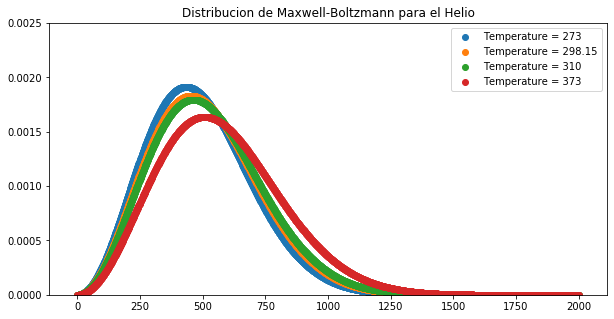

In [36]:
fig, ax = plt.subplots(figsize=(10,5))
T = [273,298.15,310,373]
v = np.linspace(0,2000,2000)
for temp in T:
    ax.scatter(v,MaxwBltz(v,M=helium_m,T=temp), label=f'Temperature = {temp}')
ax.set_ylim(0,0.0025)
ax.set_title("Distribucion de Maxwell-Boltzmann para el Helio")
plt.legend()

A mayor temperatura, velocidades más altas tienen mayor probabilidad. Además, la media de la distribución incrementa.

### 3.3.3

$$
\begin{align*}
v_{avg} &= \int_0^\infty vP(v) dv
    \end{align*}
$$

In [37]:
def sustitucion(u,M = helium_m,T=298.15):
    R = boltzmann_k
    return ((2*R*T*u)/M)*4*np.pi*(M/(2*np.pi*R*T))**(3/2)*(2*R*T)/(2*M)

In [38]:
n = 4
x = sym.Symbol('x',real=True)
xk = GetAllRootsGlag(n)
ck = GetWeightsGLag(n)

In [39]:
def velocidad_promedio(T):
    return sum(ck*sustitucion(xk,T=T))

In [40]:
T = np.array([250,260,273,280,298.15,300,310,320,350,373])
promedios=np.array([])
for temp in T:
    promedio = velocidad_promedio(temp)
    promedios = np.append(promedios,promedio)
promedios

array([468.60888047, 477.88916516, 489.69067469, 495.92902396,
       511.75007742, 513.33530897, 521.82076496, 530.17042737,
       554.46550479, 572.39380677])

$$
\begin{align*}
    v_{avg} &= \sqrt{\frac{8RT}{\pi M}}
\end{align*}
$$

In [41]:
#Valor teorico
def valoresperado(T):
    return np.sqrt((8*boltzmann_k*T)/(np.pi*helium_m))

In [42]:
expected_values = valoresperado(T)
print("**Error de aproximacion**")
np.abs(expected_values-promedios)

**Error de aproximacion**


array([2.84217094e-13, 3.41060513e-13, 3.41060513e-13, 3.41060513e-13,
       2.84217094e-13, 4.54747351e-13, 3.41060513e-13, 3.41060513e-13,
       5.68434189e-13, 3.41060513e-13])

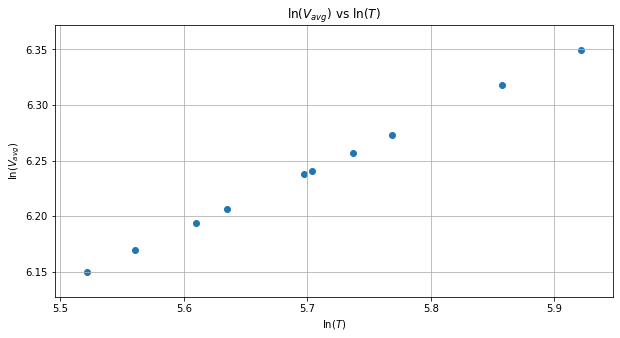

In [43]:
fig,ax = plt.subplots(figsize=(10,5))
lntemp = np.log(T)
lnavg = np.log(promedios)
lnmean = np.log(expected_values)
ax.scatter(lntemp,lnavg)
plt.xlabel(r"$\ln(T)$")
plt.ylabel(r"$\ln(V_{avg})$")
ax.set_title(r"$\ln(V_{avg})$ vs $\ln(T)$")
plt.grid()

### 3.3.4

$$
\begin{align*}
        v_{rms} &= \sqrt{\int_{0}^\infty v^2 P(v) dv} 
    \end{align*}
$$

In [44]:
def sustitucion(u,M=helium_m ,T=298.15):
    R = boltzmann_k
    temp = np.sqrt((2*R*T*u)/M)
    return ((2*R*T*u)/M)*4*np.pi*(M/(2*np.pi*R*T))**(3/2)*((2*R*T)/(2*M))*temp
    return 

In [45]:
n = 7
x = sym.Symbol('x',real=True)
xk = GetAllRootsGlag(n)
ck = GetWeightsGLag(n)

In [46]:
def fun_vrms(T):
    return np.sqrt(sum(ck*sustitucion(xk,T=T)))

In [47]:
T = np.array([250,260,273,280,298.15,300,310,320,350,373])
vrms =np.array([])

for temp in T:
    value = fun_vrms(temp)
    vrms = np.append(vrms,value)
    
vrms

array([508.63174295, 518.70463651, 531.51408724, 538.28524031,
       555.45753544, 557.17815816, 566.38833844, 575.45112731,
       601.8211943 , 621.28071345])

In [48]:
def theoric_vrms(T):
    '''velocidad media cuadratica toerica'''
    return np.sqrt((3*boltzmann_k*T)/(helium_m))

$$
\begin{align*}
        v_{rms} &= \sqrt{\frac{3RT}{M}}
    \end{align*}
$$

In [49]:
t_vrms = theoric_vrms(T)
print("**Error de aproximacion**")
np.abs(vrms-t_vrms)

**Error de aproximacion**


array([0.00278224, 0.00283734, 0.00290741, 0.00294445, 0.00303838,
       0.00304779, 0.00309817, 0.00314775, 0.00329199, 0.00339844])

Text(0.5, 1.0, '$\\ln(V_{rms})$ vs $\\ln(T)$')

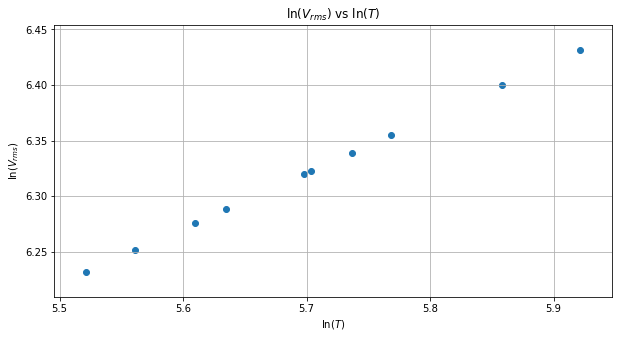

In [50]:
fig,ax = plt.subplots(figsize=(10,5))
lntemp = np.log(T)
lnvrms = np.log(vrms)
ax.scatter(lntemp,lnvrms)
plt.xlabel(r"$\ln(T)$")
plt.ylabel(r"$\ln(V_{rms})$")
plt.grid()
ax.set_title(r"$\ln(V_{rms})$ vs $\ln(T)$")

### 3.3.5

Energia interna de un gas